**Load Library**

In [1]:
import os
import spacy
import pandas as pd
import numpy as np
import geopandas as gpd
import re
import math
import string
import unicodedata
import gensim
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
import contextily as ctx
import urllib.request
import ast  # 用于安全地将字符串转换为列表
import umap

from scipy.spatial.distance import cdist

from shapely.geometry import Point

from sklearn.preprocessing import OneHotEncoder  # We don't use this but I point out where you *could*
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.svm import SVC



from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk import ngrams, FreqDist

from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.matutils import Sparse2Corpus
from gensim.matutils import corpus2dense
from gensim.models import tfidfmodel
from gensim.models import Word2Vec
from gensim.models import TfidfModel
from gensim.models import KeyedVectors
from gensim.models.ldamodel import LdaModel

from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS

from joblib import dump
from joblib import load



In [2]:
Airbnb_Listing = pd.read_csv(os.path.join("..","Data","Airbnb_Listing_norm.csv"))

In [3]:
texts_word2vec = Airbnb_Listing['amenities_norm']

In [4]:
# 从norm并且split后的数据读取csv
amenities_norm_split = pd.read_csv(os.path.join("..","Data","amenities_norm_split.csv"),low_memory=False)

# 将 'amenities' 列中的字符串转换为列表
# 使用 ast.literal_eval 安全地评估字符串表达的列表
amenities_ast_literal = amenities_norm_split
amenities_ast_literal.drop('Unnamed: 0',axis=1)

,0,1,2,3,4,5,6,7,8,9,...,208,209,210,211,212,213,214,215,216,217
0,heating,standard,cable,wifi,smoke,alarm,dryer,kitchen,washer,essentials,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,window,guard,bathtub,water,kettle,laundromat,nearby,indoor,fireplace,microwave,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,bathtub,water,kettle,laundromat,nearby,private,patio,balcony,paid,street,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,shampoo,luggage,dropoff,allow,dryer,microwave,coffee,maker,water,iron,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,window,guard,bathtub,water,kettle,laundromat,nearby,free,driveway,park,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87941,water,kettle,laundromat,nearby,shampoo,luggage,dropoff,allow,dryer,coffee,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87942,bathtub,free,dryer,unit,water,kettle,private,patio,balcony,fire,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87943,window,guard,bathtub,water,kettle,laundromat,nearby,paid,street,park,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87944,water,kettle,dryer,microwave,coffee,maker,linens,iron,patio,balcony,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
list_of_lists = amenities_ast_literal.apply(lambda row: [item for item in row if item is not None], axis=1).tolist()

print(len(list_of_lists))

87946


In [7]:
# 准备用于 Word2Vec 的数据
# list_of_lists

# 指定训练参数
dims = 200
window = 20

# 训练 Word2Vec 模型
model = Word2Vec(sentences=list_of_lists, vector_size=dims, window=window, min_count=3, workers=4)

In [8]:
# 保存word2vec模型
model.save(os.path.join("..","Model",f"word2vec-d{dims}-w{window}.model"))

In [8]:
"""# 随机森林方法 Random Forest

#使用任何类型的分类器来预测是否income超过平均值
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(doc_vectors, Airbnb_Listing['profitable'], test_size=0.2, random_state=42)

# 训练分类器
classifier = RandomForestClassifier(n_estimators=300, random_state=42)
classifier.fit(X_train, y_train)

# 预测测试集
y_pred = classifier.predict(X_test)

# 评估模型
print("Accuracy:", accuracy_score(y_test, y_pred))
"""

Accuracy: 0.8054007959067652


In [17]:
#SVM方法
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(doc_vectors, Airbnb_Listing['profitable'], test_size=0.2, random_state=42)

# 创建 SVM 分类器实例
svm_classifier = SVC(random_state=42)

# 训练分类器
svm_classifier.fit(X_train, y_train)

# 预测测试集
y_pred = svm_classifier.predict(X_test)

# 评估模型
print("Accuracy:", accuracy_score(y_test, y_pred))



Accuracy: 0.7957362137578169


保存SVM模型与保存后的Airbnb_Listing_norm_income

In [11]:
dump(classifier, 'randforest_classfier_model.joblib')
dump(svm_classifier, 'svm_classfier_model.joblib')

['svm_classfier_model.joblib']

读取导入word2vec模型


In [6]:
# import Word2Vec Model from index
word2vec_model = Word2Vec.load(os.path.join("..","Model","word2vec-d500-w20.model"))

将训练后model应用于'amenities'列

In [7]:

"""# 预处理函数
def preprocess(text):
    # 这里添加文本清洗逻辑（例如：转换为小写，去除标点等）
    return text.lower()"""

# 向量化函数
def vectorize(text, model):
    # 将文本分解为单词，并过滤掉模型词汇表中不存在的单词
    words = [word for word in text if word in model.wv.key_to_index]
    # 如果文本中没有模型已知的单词，则返回零向量
    if len(words) == 0:
        return np.zeros(model.vector_size)
    # 计算所有单词向量的平均值
    word_vectors = [model.wv[word] for word in words]
    return np.mean(word_vectors, axis=0)



In [8]:
Airbnb_Listing['amenities_vector'] = pd.Series(list_of_lists).apply(lambda x: vectorize(x, word2vec_model))

In [9]:
amenities_vector = Airbnb_Listing['amenities_vector']

In [10]:
amenities_vector.head()

0    [-1.0486246, 0.5344302, -0.083113596, -1.44642...
1    [0.2819652, -0.40748537, -0.18781887, -0.13380...
2    [0.51126474, -0.2657438, -0.09904245, 0.004234...
3    [0.08160019, -0.10968636, -0.42752135, -0.4371...
4    [0.31954134, -0.003163001, -0.2455043, -0.1549...
Name: amenities_vector, dtype: object

In [11]:
# UMAP降维可视化word2vec模型 
# 将pd.Series转换为np.array形式
amenities_vector_nparray = amenities_vector.to_numpy()

In [12]:
numpy_array = np.array([np.array(x) for x in amenities_vector_nparray])


In [13]:
reducer = umap.UMAP(n_components=2,n_neighbors=20)
embedding = reducer.fit_transform(numpy_array)

In [14]:
# 计算所有点的中心坐标
center = embedding.mean(axis=0)

# 计算平移量
translation = -center

# 对所有点应用平移变换
translated_embedding = embedding + translation

# 验证新的中心点
new_center = translated_embedding.mean(axis=0)
print(f"New center after translation: {new_center}")

New center after translation: [-8.140475e-05  6.418813e-05]


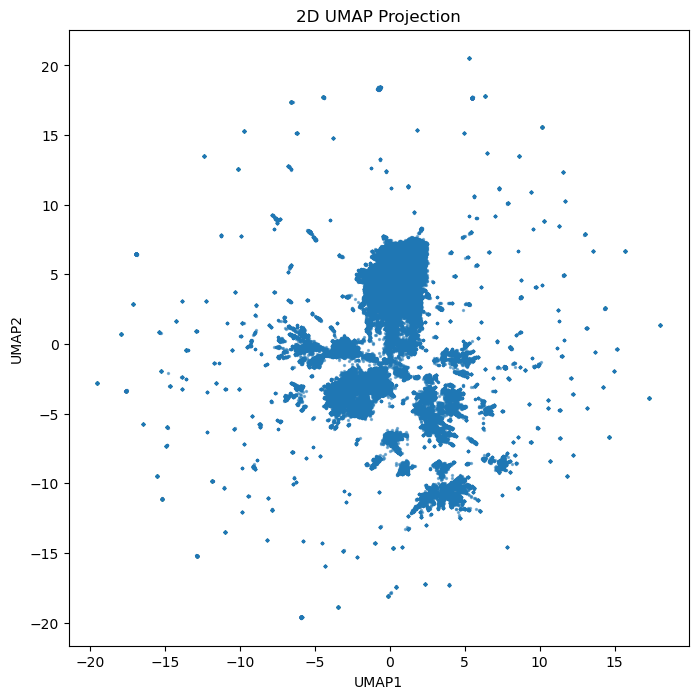

In [15]:
plt.figure(figsize=(8, 8))

plt.scatter(translated_embedding[:, 0], translated_embedding[:, 1],s=2, alpha=0.5)
plt.title('2D UMAP Projection')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

plt.savefig(os.path.join("..","Images","Word2Vec_2D_UMAP_Projection.png"), dpi=300)


plt.show()